Loading files

In [1]:
!wget https://raw.githubusercontent.com/carlosmlosa/nlp_sentences_processing/main/functions.py

!wget https://raw.githubusercontent.com/carlosmlosa/nlp_sentences_processing/main/files/anomalies.txt
!wget https://raw.githubusercontent.com/carlosmlosa/nlp_sentences_processing/main/files/threats.txt

--2021-04-11 16:14:58--  https://raw.githubusercontent.com/carlosmlosa/nlp_sentences_processing/main/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6367 (6.2K) [text/plain]
Saving to: ‘functions.py’

functions.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-04-11 16:14:58 (82.3 MB/s) - ‘functions.py’ saved [6367/6367]

--2021-04-11 16:14:58--  https://raw.githubusercontent.com/carlosmlosa/nlp_sentences_processing/main/files/anomalies.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226 

Creating anomalies and threats dictionaries

In [2]:
import functions
from functions import *
import spacy
nlp = spacy.load('en_core_web_sm')#, disable=['parser', 'ner'])

threats_file = '/content/threats.txt'
threats_dict = terms_dict(threats_file)

anomalies_file = '/content/anomalies.txt'
anomalies_dict = terms_dict(anomalies_file)

# Es necesario modificar algunas por que no detecta bien las palabras como WiFi
add_word_to_dict(anomalies_dict, 'WiFiSensorAnomaly', 'WiFi')


# Añadimos el termino 'intentional' a todos los términos que tengan la palabra 
# 'deliberated' porque 'deliberated' da problemas y sugerimos evitar esa palabra
for k,v in threats_dict.items():
  if 'Deliberated' in threats_dict[k]:
    add_word_to_dict(threats_dict,k, 'intentional')

# añadimos las palabras para el acrónimo HW
for k,v in threats_dict.items():
  if 'HW' in threats_dict[k]:
    add_word_to_dict(threats_dict,k, 'hardware')

# añadimos las palabras para el acrónimo SW
for k,v in threats_dict.items():
  if 'SW' in threats_dict[k]:
    add_word_to_dict(threats_dict,k, 'software')

threats_dict

{'Accidents': ['Accidents', 'accident'],
 'BadReputationThreat': ['Bad',
  'Reputation',
  'Threat',
  'bad',
  'reputation',
  'threat'],
 'ComplianceThreat': ['Compliance', 'Threat', 'compliance', 'threat'],
 'ConfigurationError': ['Configuration', 'Error'],
 'CorporateBrandImageDamages': ['Corporate',
  'Brand',
  'Image',
  'Damages',
  'corporate',
  'brand',
  'image',
  'damage'],
 'DataProtectionRisks': ['Data', 'Protection', 'Risks'],
 'DelayedDelivery': ['Delayed', 'Delivery', 'delay', 'delivery'],
 'DeliberatedConfigFilesTampering': ['Deliberated',
  'Config',
  'Files',
  'Tampering',
  'config',
  'file',
  'tamper',
  'intentional'],
 'DeliberatedHWTampering': ['Deliberated',
  'HW',
  'Tampering',
  'deliberate',
  'hw',
  'tamper',
  'intentional',
  'hardware'],
 'DeliberatedInformationDestruction': ['Deliberated',
  'Information',
  'Destruction',
  'deliberated',
  'intentional'],
 'DeliberatedInformationLeak': ['Deliberated',
  'Information',
  'Leak',
  'intentiona

# PARSE TREE
Spacy dependency tree is hierarchical, each word (token), has a parent (head) and one or more children. From the verb we can just find the children of the verb and complete de subject and the direct object to obtain the threat and the anomaly parse.

La funcion extract_nominal_syntagmas tiene como input la frase que queremos analizar y devuelve dos listas de palabras, una con el sujeto de la oración y la otra con el objeto directo de la oración.

Las frases las formularemos con esta estructura:

***IDS anomaly generates a denial of service threat with probability 5 and impact one***


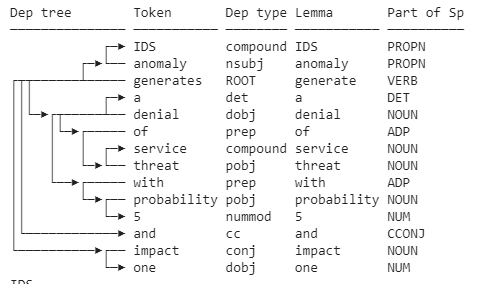


Tal y como formulamos las oraciones el **sujeto** estará relacionado con la **anomalía** y el **objeto** directo con la **amenaza** que lo causa


---


# Algoritmo para extraer los sintagmas


* Buscar verbo (`ROOT`)
* Mirar los 'hijos' (`children`) del verbo
* Buscar el sujeto (`dep_ = nsub`)
> * Hacer una lista de palabras con las dependientes del sujeto
* Buscar objeto directo (`dep_ = dobj`)
> * Hacer una lista de palabras con las dependientes del objeto directo














In [3]:
def process_anomaly_threat_sentence(sentence: str, result: {}):
  """Function that process a sentence for finding the terms prob, anomalyType, 
  threatType and impact""" 
  
  sentence = sentence.replace(",",".") # Para admitir decimales con "," o "."

  doc = nlp(str(sentence))

  anomaly = extract_subject(sentence)
  anomaly = clean(anomaly)
  anomaly_matches = search_matches(anomalies_dict, anomaly)
  anomaly_count = counter(anomaly_matches)
  anomaly = higher_frecuency_term(anomaly_count)
  result["anomalyType"] = anomaly

  threat = extract_dobject(sentence)
  threat = clean(threat)
  threat_matches = search_matches(threats_dict, threat)  
  threat_count = counter(threat_matches)  
  threat = higher_frecuency_term(threat_count)  
  result["threatType"] = threat

  result["prob"] = extract_prob(sentence)
  result["impact"] = extract_impact(sentence)
    
  return result
  # print(doc)
  # print(result)

Prueba con una frase tipo 

In [4]:
result = {
    "prob": 0,
    "impact": 0,
    "numtype": 0,
    "threatType": "",
    "anomalyType": ""
  }

sentence = "bluetooth sensor generates privilege escalation with probability 4 and impact 5"

result = process_anomaly_threat_sentence(sentence, result)
result = {"result": [result]}
write_json("results.json", result) # escribir archivo con los resultados
result

{'result': [{'anomalyType': 'BluetoothSensorAnomaly',
   'impact': 5,
   'numtype': 0,
   'prob': 4,
   'threatType': 'PrivilegeEscalation'}]}

In [5]:

result = {
    "prob": 0,
    "impact": 0,
    "numtype": 0,
    "threatType": "",
    "anomalyType": ""
  }
process_txt("prueba2.txt", process_anomaly_threat_sentence,result)

FileNotFoundError: ignored

# Test de detección de términos
Usaremos una frase tipo con el vergo generates y probaremos a usar los términos del diccionario. En primer lugar probaremos con todas las palabras y luego iremos quitando palabras hasta saber cuantas debemos poner como mínimo

In [ ]:
verb = "generates"
pandimp = "with probability 4 and impact 5"
from random import *
anomalies = load_doc('/content/anomalies.txt')
anomalies_list = []
for line in anomalies:
  clean_line = re.sub('[\W_]+', '', line)
  anomalies_list.append(clean_line)

result = {
    "prob": 0,
    "impact": 0,
    "numtype": 0,
    "threatType": "",
    "anomalyType": ""
  }

errors = 0
total = 0
for threat in threats_dict:


  anomaly = anomalies_list[5] #[randint(0,9)]
  
  expected = {
    "prob": 4,
    "impact": 5,
    "numtype": 0,
    "threatType": threat,
    "anomalyType": anomaly}

  anomaly = camel_case_split(anomaly)
  separate_anomaly = ''
  for word in anomaly:
    if word.lower() != 'anomaly':
      separate_anomaly = separate_anomaly + " " + word
  
  threat = camel_case_split(threat)
  separate_threat = ''
  for word in threat:
    if word.lower() != 'anomaly':
      separate_threat = separate_threat + " " + word

  sentence = separate_anomaly.lower() + ' ' + verb  + separate_threat.lower() + ' ' + pandimp
  print()
  print(sentence)
  
  result = process_anomaly_threat_sentence(sentence, result)
  if expected != result:
    print(expected)
    print(result)
    errors += 1
  total +=1

print(f'errores: {errors} total: {total} tasa de error: {((errors/total)*100)} %')

# Casos de fallo


*   Cuando se usa el verbo ***detects*** no siempre detecta bien el objeto directo y el sujeto 
*   evitar usar las palabras ***anomaly*** y ***threat*** dentro de la oracion porque puede dar fallo en ocasiones
*   escribir wifi separado ***wi fi*** da fallos
*   el término ***deliberated*** da problemas mejor usar la palabra ***intentional***
*   el término untrustworthy da problemas porque es un adjetivo y no lo detecta como objeto directo, por ello es necesario acompañarlo de algún sustantivo como por ejemplo ***untrustworthy source***
*   ***detected anomaly*** no lo detecta bien, mejor usar ***anomaly detection***
*   hay que usar términos muy parecidos/iguales que los de la ontología, debería ampliar el diccionario de palabras pero no se si hacerlo automático o a mano.




In [ ]:
# test deteccion de términos personalizado
test_dict = {'Accidents': ['Accidents'],
 'BadReputationThreat': ['Bad', 'Reputation'],
 'ComplianceThreat': ['Compliance'],
 'ConfigurationError': ['Configuration'],
 'CorporateBrandImageDamages': ['bad', 'Brand', 'Image','reputation'],
 'DataProtectionRisks': ['Data', 'Protection'],
 'DelayedDelivery': ['Delayed', 'Delivery'],
 'DeliberatedConfigFilesTampering': [
  'intentional',
  'Configuration',
  'Files',
  'Tampering'],
 'DeliberatedHWTampering': [  'intentional','hardware', 'Tampering'],
 'DeliberatedInformationDestruction': [
  'intentional',
  'Information',
  'Destruction'],
 'DeliberatedInformationLeak': ['intentional',
  'Information',
  'Leak'],
 'DeliberatedInformationTampering': ['intentional',
  'Information',
  'Tampering'],
 'DeliberatedMaliciousSWDistribution': [ 'intentional',
  'Malicious',
  'SW',
  'Distribution'],
 'DeliberatedRegistersTampering': ['intentional',
  'Registers',
  'Tampering'],
 'DeliberatedSWTampering': [ 'intentional', 'SW', 'Tampering'],
 'DeliberatedThreat': ['intentional', 'Threat'],
 'DeliberatedUnauthorizedAccess': [
  'Unauthorized',
  'Access'],
 'DenialOfService': ['Denial', 'Service'],
 'DeviceLost': ['Device', 'Lost'],
 'DeviceTheft': ['Device', 'robbed'],
 'EconomicLoss': ['Loss'],
 'Fire': ['Fire'],
 'HWMaintenanceError': ['hardware', 'Maintenance', 'Error'],
 'HumanResourcesNotAvailable': ['Human', 'Resources', 'Not', 'Available'],
 'HumanThreat': ['Human', 'Threat'],
 'ICTThreat': ['ICT', 'Threat'],
 'IdentityThief': ['Identity', 'Thief'],
 'InsiderThreats': ['Insider', 'Threats'],
 'MonitoringError': ['Monitoring', 'Error'],
 'NaturalDisasters': ['Natural', 'Disasters'],
 'NetworkOutage': ['Network', 'Outage'],
 'NonIntentionalAdminError': ['Non', 'Intentional', 'Admin', 'Error'],
 'NonIntentionalInformationDestruction': ['Non',
  'Intentional',
  'Information',
  'deletion'],
 'NonIntentionalInformationLeak': ['Non',
  'Intentional',
  'Information',
  'Leak'],
 'NonIntentionalInformationTampering': ['Non',
  'Intentional',
  'Information',
  'Tampering'],
 'NonIntentionalMaliciousSWDistribution': ['Non',
  'Intentional',
  'malware',
  'Distribution'],
 'NonIntentionalUserError': ['User', 'Error'],
 'OtherLegalObligationRisks': ['Legal','Risks'],
 'PartnershipsIssues': ['Partnerships', 'Issues'],
 'PhysicalFault': ['Physical', 'Fault'],
 'PhysicalThreat': ['Physical', 'Threat'],
 'PowerOutage': ['Power', 'Outage'],
 'PrivilegeEscalation': ['Privilege', 'Escalation'],
 'QualityProcessThreat': ['Quality', 'Process', 'Threat'],
 'SWMaintenanceError': ['software', 'Maintenance', 'Error'],
 'SWVulnerabilities': ['software', 'Vulnerabilities'],
 'SocialEngineering': ['Social', 'Engineering'],
 'StakeholdersIssues': ['Stakeholders', 'Issues'],
 'StakeholdersSatisfaction': ['Stakeholders', 'Satisfaction'],
 'StrategicPlanOnRisk': ['Plan','Risk'],
 'StrategicThreat': ['Strategic', 'Threat'],
 'TechnicalComplexity': ['Technical', 'Complexity'],
 'Terrorism': ['ciber','Terrorism'],
 'Threat': ['Threat'],
 'UnexpectedUsage': ['Unexpected', 'Usage'],
 'UnintentionalThreat': ['Unintentional', 'Threat'],
 'Untrustworthy': ['Untrustworthy'],
 'UsersComplaints': ['Users', 'Complaints']}


verb = "generates"
pandimp = "with probability 4 and impact 5"
from random import *
anomalies = load_doc('/content/anomalies.txt')
anomalies_list = []
for line in anomalies:
  clean_line = re.sub('[\W_]+', '', line)
  anomalies_list.append(clean_line)

result = {
    "prob": 0,
    "impact": 0,
    "numtype": 0,
    "threatType": "",
    "anomalyType": ""
  }

errors = 0
total = 0
for threat, words in test_dict.items():


  anomaly = anomalies_list[5] #[randint(0,9)]
  
  expected = {
    "prob": 4,
    "impact": 5,
    "numtype": 0,
    "threatType": threat,
    "anomalyType": anomaly}

  anomaly = camel_case_split(anomaly)
  separate_anomaly = ''
  for word in anomaly:
    if word.lower() != 'anomaly':
      separate_anomaly = separate_anomaly + " " + word
  
  separate_threat = ''
  for word in words:
    if word.lower() != 'anomaly':
      separate_threat = separate_threat + " " + word

  sentence = separate_anomaly.lower() + ' ' + verb  + separate_threat.lower() + ' ' + pandimp
  print()
  print(sentence)
  
  result = process_anomaly_threat_sentence(sentence, result)
  if expected != result:
    print(expected)
    print(result)
    errors += 1
  total +=1

print(f'errores: {errors} total: {total} tasa de error: {((errors/total)*100)} %')

In [ ]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

In [ ]:
import explacy

sentence = 'corporate brand image damages threat may generate an accident risk, fire risk, flooding risk, natural disaster risk or terrorism attack'
nlp = spacy.load('en')

explacy.print_parse_info(nlp, sentence)

# for sentence in sentences:
#   explacy.print_parse_info(nlp, sentence)